# Final Results

This is the culmination of the work done in the previous notebooks. The relevant proteins and genes which will be useful for predicting the metadata have been extracted at this point (in Proteomics.ipynb and RNA-Seq.ipynb). Now those genes will be used in the training data along with the metadata dmmy variables. The objective is to predict mislabeled samples. The results are exported to a csv file. 

In [19]:
!ls
#######################################################################

Final Results.ipynb
Finding available proteins (not NaN).ipynb
Gender Visual.ipynb
Import.ipynb
MSI Visual.ipynb
Proteomics.ipynb
RNA-Seq.ipynb
__pycache__
preprocess.py
raw_data
subchallenge_2.csv


In [20]:
import sys
import os
from IPython.utils import io
from io import StringIO

import re
import csv

import pandas as pd
import numpy as np
import scipy 
from scipy.cluster import hierarchy as hc # for dendograms 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# %matplotlib notebook

from sklearn.metrics import f1_score # f1_score(y_true, y_pred)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel

## Import & show data 

The initial data proprocess was done in the Import.ipynb notebook. The following three steps are performed in all other jupyter notebooks: run the preprocess.py code that was generated in Import.ipynb, run the %whos magic command to see what dataframes have been imported, and then format the captured %who results with pandas to view results. 

In [24]:
%run preprocess.py
# made in Import.ipynb

In [22]:
with io.capture_output() as captured:
    %whos DataFrame 

s = re.findall(r'\S+|\n', StringIO(captured.stdout).getvalue())

In [23]:
table = []
row = []

for item in s:
    if (item == '\n'):
        if (row):
            table.append(row)
        row = []
    elif re.match('^(?!-)', item) is None:
        pass        
    else: 
        row.append(item)

for item in table: 
    if (item[0] == 'Variable'):
        pass
    else:
        item[2:] = [' , '.join(item[2:])]

df = pd.DataFrame(data=table[1:], columns=table[0])
pd.set_option('display.max_colwidth', -1)
df

,Variable,Type,Data/Info
0,X_rnapro_important_train_df,DataFrame,"0 , 1 , 2 , 3 , 4 , 5 , 6 , <...>\n[56 , rows , x , 169 , columns]"
1,df,DataFrame,"Variable , <...> , , , x , , , 17450 , , , columns]"
2,df_test_cli,DataFrame,"sample , gender , <...>g_80 , Female , MSI-High"
3,df_test_pro,DataFrame,"A1BG , <...>n[80 , rows , x , 4118 , columns]"
4,df_test_rna,DataFrame,"A1BG , A1B<...>[80 , rows , x , 17447 , columns]"
5,df_train_cli,DataFrame,"sample , gender , <...>g_80 , Female , MSI-Low/MSS"
6,df_train_mislabel,DataFrame,"sample , mismatch<...>79 , Training_80 , 1"
7,df_train_pro,DataFrame,"A1BG , <...>n[80 , rows , x , 4118 , columns]"
8,df_train_rna,DataFrame,"A1BG , A1<...>[80 , rows , x , 17447 , columns]"
9,test_cli,DataFrame,"gender , msi\n<...>\nTesting_80 , 1 , 1"


#### the following dataframes are too large for the outputs to be neatly outputed in github. Their information is included in the above table. 

In [25]:
# train_pro_combined
# train_rna_combined
# train_combined

## Extract the relevant attributes

The following genes are results of the proteomics, RNA-seq and the availability notebook to pick the proteins and genes that are not listed as NaN in the raw data so the classification would be more accurate. 

In [26]:
train_rnapro = train_combined[
    
    ['gender', 'msi', 
    # msi proteomics
    'TAP1', 'LCP1', 'PTPN6', 'CASK', 'ICAM1', 'ITGB2',
    'CKB', 'LAP3', 'PTPRC', 'HSDL2', 'WARS',
    'IFI35', 'TYMP', 'TAPBP', 'ERMP1', 'ANP32E',
    'ROCK2', 'CNDP2', 'RFTN1', 'GBP1',
    'NCF2', 'YARS2', 'RPL3', 'ENO1', 'SNX12', 'ARL3',

     # mis rna-seq 
    'EPDR1', 'APOL3', 'POU5F1B', 'CFTR', 'CIITA', 'MAX',
    'PRSS23', 'FABP6', 'GABRP', 'LAP3', 'SLC19A3', 'WARS',
    'GBP1', 'RAMP1', 'AREG',
    'EREG', 'TNNC2', 'ANKRD27', 'PLCL2', 'TFCP2L1', 'LAG3', 'GRM8', 
    'BEX2', 'DEFB1', 'IRF1', 'CCL4', 'SLC51B', 
    'GBP4', 'HPSE',

    # gender proteomics
    'EMILIN1', 'EIF4G2', 'ARFIP1', 'GAR1',
    'TJP2', 'ALDH1A1', 'PGM2', 'LTBP1', 'NNMT', 'COX7C', 'FBN1',
    'SERPINB1', 'U2AF1L5', 'COG3', 'FBLN1', 'FLNC', 
    'NAP1L1', 'AGRN', 'RCC2', 'COL4A2', 'S100A14', 

    # gender rna-seq 
    'ZFX', 'SRSF6', 'ZRSR2', 
    'EVPL', 'LUC7L2', 'ZNF862', 'ODAM', 'RGS4', 
    'FOXD2', 'PMS2P3', 'MND1', 'FAM3D', 'DDB2', 'THG1L',
    'DDX3X', 'NINJ2', 'COCH', 'IRF5', 'FHDC1', 'ZNF606', 
    'FBXW9', 'RPL21P28', 'TLX1', 'HEBP2', 'TRIM29', 'ZNF273', 'KCNJ2', 
    'CRABP2', 'ABCA6', 'MMP17', 'PCNA', 'S100A16', 'UBA6', 'EHBP1', 
    ]
                                ]

columns = train_rnapro.columns
# train_rnapro

## Begin the final classification test 

Here, the combined data (rnapro means rna-seq and proteins) is broken down into training and test set to train the final classification model. 

In [8]:
X_rnapro_train, X_rnapro_valid, y_rnapro_train, y_rnapro_valid =\
\
    train_test_split(train_rnapro.values.astype(int),
                     train_combined.mismatch.values, 
                     test_size=0.3)

#### This graph shows that few proteins and genes together can predict mislabeled with high accuracy

 1) S100A14                        0.317996
 2) ROCK2                          0.076224
 3) FHDC1                          0.070500
 4) PGM2                           0.053463
 5) GAR1                           0.041704
 6) ALDH1A1                        0.026214
 7) S100A14                        0.018250
 8) CNDP2                          0.017275
 9) SRSF6                          0.013828
10) FAM3D                          0.012934
11) GAR1                           0.012476
12) IRF5                           0.012183
13) S100A16                        0.010339
14) RPL21P28                       0.009908
15) SNX12                          0.009894
16) KCNJ2                          0.009300
17) TJP2                           0.009181
18) CCL4                           0.007946
19) HSDL2                          0.007361
20) ODAM                           0.007187
21) SRSF6                          0.007153
22) PLCL2                          0.006971
23) CKB                         

<BarContainer object of 169 artists>

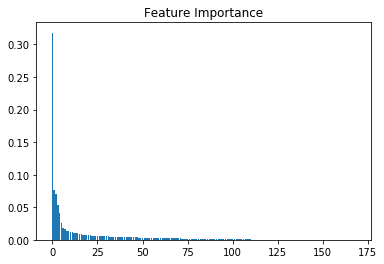

In [9]:
rnapro_forest = RandomForestClassifier(n_estimators=500, 
                                      min_samples_leaf=3,
                                      max_features=None,
                                      n_jobs=-1,
                                      oob_score=True)

rnapro_forest.fit(X_rnapro_train, y_rnapro_train)

rnapro_importances = rnapro_forest.feature_importances_

rnapro_indices = np.argsort(rnapro_importances)[::-1]

# for f in range(X_train.shape[1]): # to get the full results
for f in range(len(columns)):
    print("%2d) %-*s %f" % (f + 1, 
                            30, 
                            columns[rnapro_indices[f]], 
                            rnapro_importances[rnapro_indices[f]]))
    
plt.title('Feature Importance')

plt.bar(range(X_rnapro_train.shape[1]), 
        rnapro_importances[rnapro_indices], 
        align='center')

#### this is measuring how well the model is doing. It is shows that even with a relatively simple method (random forests) an acceptable outcome is reached. A better method would have been an appropriate an trained neural network. 

In [27]:
rnapro_select = SelectFromModel(rnapro_forest, threshold=0.0)

rnapro_select.fit(X_rnapro_train, y_rnapro_train)

X_rnapro_important_train = rnapro_select.transform(X_rnapro_train)
X_rnapro_important_train_df = pd.DataFrame(X_rnapro_important_train)
X_rnapro_important_valid = rnapro_select.transform(X_rnapro_valid)
rnapro_forest.fit(X_rnapro_important_train, y_rnapro_train)
y_rnapro_pred = rnapro_forest.predict(X_rnapro_important_valid)

print('Random Forest: \n', 
      classification_report(y_true=y_rnapro_valid, 
                            y_pred=y_rnapro_pred))

print('OOB score: ', rnapro_forest.oob_score_)

Random Forest: 
              precision    recall  f1-score   support

          0       0.75      1.00      0.86        18
          1       0.00      0.00      0.00         6

avg / total       0.56      0.75      0.64        24

OOB score:  0.8928571428571429


/Users/hossainpazooki/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

f1_scorer = make_scorer(f1_score, average='binary', pos_label=1,)

## Gridsearch 

here the final grid search for optimizing the classifier is used. the results are used in the next cell, but because of too many warnings the output is suppressed on github. 

afterwards the model is trained and outputed to a csv file.

In [14]:
forest = RandomForestClassifier(n_estimators=500, 
                                n_jobs=-1, 
                                oob_score=True)

# sorted(forest.get_params().keys())

gs = GridSearchCV(estimator=forest,
                  param_grid=[
                      {'min_samples_leaf':[1, 3, 5, 10, 25, 100],
                       'criterion':['gini','entropy'],
                       'max_depth' : [1, 5, 10, 15, 20, 25, 30],
                       'max_features':[None, 0.5, 'sqrt', 'log2']}],
                  scoring=f1_scorer,
                  cv=10,
                  n_jobs=-1)

gs = gs.fit(train_rnapro.values.astype(int), 
            train_combined.mismatch.values)

print(gs.best_score_)
print(gs.best_params_)

In [29]:
test_pro.reset_index(drop=True, inplace=True)
test_cli.reset_index(drop=True, inplace=True)
test_rna.reset_index(drop=True, inplace=True)
test_combined = pd.concat([test_cli, test_pro, test_rna], axis=1)

test_final = test_combined[
    
    ['gender', 'msi', 
    # msi proteomics
    'TAP1', 'LCP1', 'PTPN6', 'CASK', 'ICAM1', 'ITGB2',
    'CKB', 'LAP3', 'PTPRC', 'HSDL2', 'WARS',
    'IFI35', 'TYMP', 'TAPBP', 'ERMP1', 'ANP32E',
    'ROCK2', 'CNDP2', 'RFTN1', 'GBP1',
    'NCF2', 'YARS2', 'RPL3', 'ENO1', 'SNX12', 'ARL3',
                
     # mis rna-seq 
    'EPDR1', 'APOL3', 'POU5F1B', 'CFTR', 'CIITA', 'MAX',
    'PRSS23', 'FABP6', 'GABRP', 'LAP3', 'SLC19A3', 'WARS',
    'GBP1', 'RAMP1', 'AREG',
    'EREG', 'TNNC2', 'ANKRD27', 'PLCL2', 'TFCP2L1', 'LAG3', 'GRM8', 
    'BEX2', 'DEFB1', 'IRF1', 'CCL4', 'SLC51B', 
    'GBP4', 'HPSE',

    # gender proteomics
    'EMILIN1', 'EIF4G2', 'ARFIP1', 'GAR1',
    'TJP2', 'ALDH1A1', 'PGM2', 'LTBP1', 'NNMT', 'COX7C', 'FBN1',
    'SERPINB1', 'U2AF1L5', 'COG3', 'FBLN1', 'FLNC', 
    'NAP1L1', 'AGRN', 'RCC2', 'COL4A2', 'S100A14', 

    # gender rna-seq 
    'ZFX', 'SRSF6', 'ZRSR2', 
    'EVPL', 'LUC7L2', 'ZNF862', 'ODAM', 'RGS4', 'EHBP1', 'THG1L',
    'FOXD2', 'PMS2P3', 'MND1', 'FAM3D', 'DDB2', 'KCNJ2', 
    'DDX3X', 'NINJ2', 'COCH', 'IRF5', 'FHDC1', 'ZNF606', 
    'FBXW9', 'RPL21P28', 'TLX1', 'HEBP2', 'TRIM29', 'ZNF273', 
    'CRABP2', 'ABCA6', 'MMP17', 'PCNA', 'S100A16', 'UBA6', 
    ]
                            ]

X_test = test_final.values.astype(int)

In [30]:
forest.fit(train_rnapro.values.astype(int), 
           train_combined.mismatch.values)

y_pred = forest.predict(X_test)

y_pred_df = pd.DataFrame(y_pred)

y_pred_df.to_csv('subchallenge_2.csv')

In [31]:
y_pred_df

,0
0,0
1,0
2,0
3,0
4,1
5,0
6,0
7,1
8,0
9,0
